# N sites unitaries optimisation sweep

Created 01/08/2024

Objectives:
* Apply N site optimisation to all wavefunctions, perform "final" check on results.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from time import perf_counter

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries
from SPTOptimization.Optimizers.OneSiteSolver import OneSiteSolver
from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment
)

# Load data

In [6]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [7]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [8]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [9]:
psi_dict = dict()

In [10]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitons

In [11]:
TOLERANCE = 0.005

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [14]:
small_symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [15]:
big_symmetry_actions = [l*50 for l in small_symmetry_actions]

In [16]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [18]:
symmetry_actions_with_boundary_unitaries = [
    [
        SymmetryActionWithBoundaryUnitaries(p, s)
        for p in psi_dict.values()
    ]
    for s in big_symmetry_actions
]

In [19]:
for l in symmetry_actions_with_boundary_unitaries:
    for e in l:
        e.compute_svd_approximate_expectation()

# Optimisation code

In [20]:
def optimise_step_right(psi, prev_t, boundary_index, site_index,
    prev_top_legs, prev_bottom_legs):

    b = psi.get_B(site_index)

    new_top_leg = 'p_{}'.format(boundary_index)
    new_top_legs = prev_top_legs + [new_top_leg,]

    t = npc.tensordot(prev_t, b, [['vR',],  ['vL',]])        
    t=t.replace_label('p', new_top_leg)

    
    new_bottom_leg = 'p*_{}'.format(boundary_index)
    new_bottom_legs = prev_bottom_legs + [new_bottom_leg,]

    t = npc.tensordot(t, b.conj(), [['vR*',],  ['vL*',]])
    t=t.replace_label('p*', new_bottom_leg)

    t0 = t.combine_legs(new_top_legs).combine_legs(new_bottom_legs)
    t0 = npc.trace(t0, leg1='vR', leg2='vR*')
    
    U, S, VH = npc.svd(t0.complex_conj(), inner_labels = ['i', 'i*'])

    out_exp = np.sum(S)
    out_unitary = npc.tensordot(U, VH, [['i',], ['i*',]])

    return (
        t,
        new_top_legs,
        new_bottom_legs,
        out_exp,
        out_unitary
    )

In [21]:
def optimise_step_left(psi, prev_t, boundary_index, site_index,
    prev_top_legs, prev_bottom_legs):

    a = psi.get_B(site_index, form='A')

    new_top_leg = 'p_{}'.format(boundary_index)
    new_top_legs = prev_top_legs + [new_top_leg,]

    t = npc.tensordot(prev_t, a, [['vL',],  ['vR',]])        
    t=t.replace_label('p', new_top_leg)
    
    new_bottom_leg = 'p*_{}'.format(boundary_index)
    new_bottom_legs = prev_bottom_legs + [new_bottom_leg,]

    t = npc.tensordot(t, a.conj(), [['vL*',],  ['vR*',]])
    t=t.replace_label('p*', new_bottom_leg)

    t0 = t.combine_legs(new_top_legs).combine_legs(new_bottom_legs)
    t0 = npc.trace(t0, leg1='vL', leg2='vL*')

    U, S, VH = npc.svd(t0.complex_conj(), inner_labels = ['i', 'i*'])

    out_exp = np.sum(S)
    out_unitary = npc.tensordot(U, VH, [['i',], ['i*',]])

    return (
        t,
        new_top_legs,
        new_bottom_legs,
        out_exp,
        out_unitary
    )

In [28]:
def optimise(symmetry_action, tolerance=TOLERANCE, max_num_sites=8):
    psi = symmetry_action.psi
    sing_val = symmetry_action.symmetry_transfer_matrix_singular_vals[0]

    left_site_index = symmetry_action.left_symmetry_index
    right_site_index = symmetry_action.right_symmetry_index
    
    left_t = symmetry_action.left_projected_symmetry_state
    right_t = symmetry_action.right_projected_symmetry_state

    num_sites = 0
    left_exps = list()
    right_exps = list()
    left_times = list()
    right_times = list()
    exps = list()
    left_unitary = None
    right_unitary = None
    right_top_legs = list()
    right_bottom_legs = list()
    left_top_legs = list()
    left_bottom_legs = list()
    right_boundary_index = 0
    left_boundary_index = 0

    while (not exps) or ((exps[-1] < 1-tolerance) and (num_sites <= max_num_sites)):
        num_sites += 1

        tic = perf_counter()

        right_boundary_index += 1
        right_site_index += 1
        right_out = optimise_step_right(
            psi,
            right_t,
            right_boundary_index,
            right_site_index,
            right_top_legs,
            right_bottom_legs
        )

        (
            right_t,
            right_top_legs,
            right_bottom_legs,
            right_exp,
            right_unitary
        ) = right_out

        right_exps.append(right_exp)
        
        toc = perf_counter()
        right_times.append(toc-tic)

        tic = perf_counter()

        left_boundary_index += 1
        left_site_index -= 1
        left_out = optimise_step_left(
            psi,
            left_t,
            left_boundary_index,
            left_site_index,
            left_top_legs,
            left_bottom_legs
        )

        (
            left_t,
            left_top_legs,
            left_bottom_legs,
            left_exp,
            left_unitary
        ) = left_out

        left_exps.append(left_exp)
        
        toc = perf_counter()
        left_times.append(toc-tic)

        exps.append(left_exp*sing_val*right_exp)

    return (
        left_exps,
        right_exps,
        left_times,
        right_times,
        exps,
        left_unitary,
        right_unitary
    )

In [29]:
out = optimise(symmetry_actions_with_boundary_unitaries[0][0])

In [30]:
out

([1.4142135623730951],
 [1.4142135623730954],
 [0.002834291022736579],
 [0.013029541994910687],
 [0.999999999999999],
 <npc.Array shape=(2, 2) labels=['(p_1)', '(p*_1)']>,
 <npc.Array shape=(2, 2) labels=['(p_1)', '(p*_1)']>)

In [31]:
out = optimise(symmetry_actions_with_boundary_unitaries[2][5])

In [32]:
out

([1.3651471712007188,
  1.3651471712007188,
  1.407161495410036,
  1.4071614954120863,
  1.4136300795049344,
  1.413630079504935],
 [8.137336475797976e-08,
  1.36514717120072,
  1.36514717120072,
  1.4071614954255984,
  1.4071614955090552,
  1.4136300795049312],
 [0.0034239160013385117,
  0.006633249984588474,
  0.002678541000932455,
  0.002452499989885837,
  0.0032986669975798577,
  0.16933100001187995],
 [0.004226749995723367,
  0.004625832982128486,
  0.005911749991355464,
  0.0047756249841768295,
  0.008118792000459507,
  0.11053854200872593],
 [5.547195176892189e-08,
  0.930616280444522,
  0.9592573053434531,
  0.9887797980782852,
  0.9933251223903362,
  0.9978913409870666],
 <npc.Array shape=(64, 64) labels=['(p_1.p_2.p_3.p_4.p_5.p_6)', '(p*_1.p*_2.p*_3.p*_4.p*_5.p*_6)']>,
 <npc.Array shape=(64, 64) labels=['(p_1.p_2.p_3.p_4.p_5.p_6)', '(p*_1.p*_2.p*_3.p*_4.p*_5.p*_6)']>)

# Sweep

In [52]:
out_data =list()
for i, l in enumerate(symmetry_actions_with_boundary_unitaries):
    print("Symmetry action: {}".format(i))
    out_data.append(list())
    for j, e in enumerate(l):
        print("Wavefunction: {}".format(j))
        (out_data[-1]).append(optimise(e, max_num_sites=9))

Symmetry action: 0
Wavefunction: 0
Wavefunction: 1
Wavefunction: 2
Wavefunction: 3
Wavefunction: 4
Wavefunction: 5
Wavefunction: 6
Wavefunction: 7
Wavefunction: 8
Wavefunction: 9
Wavefunction: 10
Wavefunction: 11
Wavefunction: 12
Wavefunction: 13
Wavefunction: 14
Wavefunction: 15
Wavefunction: 16
Wavefunction: 17
Wavefunction: 18
Wavefunction: 19
Wavefunction: 20
Symmetry action: 1
Wavefunction: 0
Wavefunction: 1
Wavefunction: 2
Wavefunction: 3
Wavefunction: 4
Wavefunction: 5
Wavefunction: 6
Wavefunction: 7
Wavefunction: 8
Wavefunction: 9
Wavefunction: 10
Wavefunction: 11
Wavefunction: 12
Wavefunction: 13
Wavefunction: 14
Wavefunction: 15
Wavefunction: 16
Wavefunction: 17
Wavefunction: 18
Wavefunction: 19
Wavefunction: 20
Symmetry action: 2
Wavefunction: 0
Wavefunction: 1
Wavefunction: 2
Wavefunction: 3
Wavefunction: 4
Wavefunction: 5
Wavefunction: 6
Wavefunction: 7
Wavefunction: 8
Wavefunction: 9
Wavefunction: 10
Wavefunction: 11
Wavefunction: 12
Wavefunction: 13
Wavefunction: 14
Wave

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_64605/1800624668.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


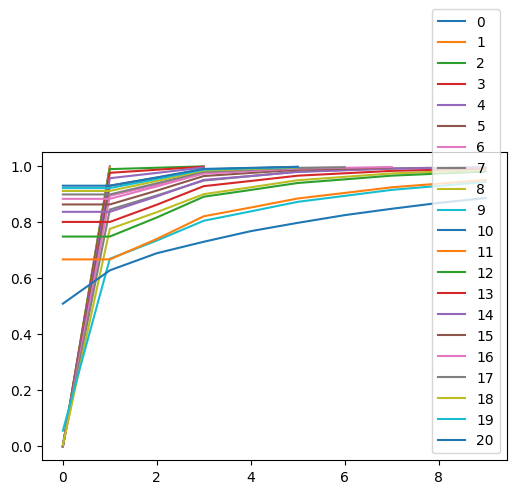

In [53]:
fig, ax = plt.subplots(figsize=(6,4))

for i, l in enumerate(out_data[2]):
    ax.plot(l[4], label=i)

ax.legend(loc='lower right')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_64605/1835966123.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


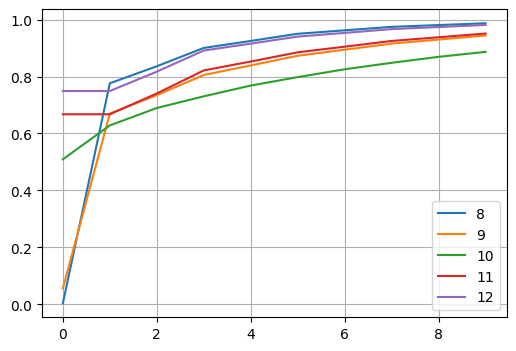

In [56]:
fig, ax = plt.subplots(figsize=(6,4))

for i, l in enumerate(out_data[2][8:13], start=8):
    ax.plot(l[4], label=i)

ax.grid()
ax.legend(loc='lower right')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_64605/3124484707.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


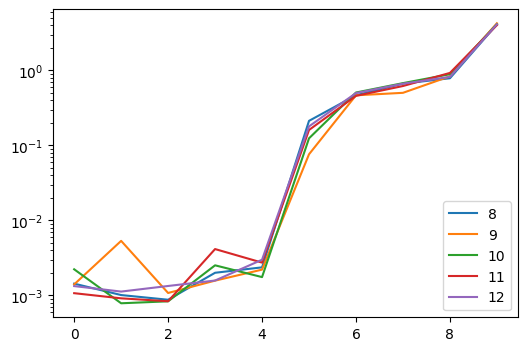

In [60]:
fig, ax = plt.subplots(figsize=(6,4))

for i, l in enumerate(out_data[2][8:13], start=8):
    ax.plot(l[2], label=i)

ax.set_yscale('log')
ax.legend(loc='lower right')
fig.show()

In [57]:
out_data[2][10][2]

[0.0022334590030368418,
 0.0007867919921409339,
 0.0008356250182259828,
 0.002523333008866757,
 0.0017576249956618994,
 0.12455958299688064,
 0.5080802500015125,
 0.677587958984077,
 0.8912625419907272,
 4.131249084020965]

In [58]:
out_data[2][10][4]

[0.509292997869385,
 0.6283401066665614,
 0.6894675810160006,
 0.7304508397665732,
 0.768311204907468,
 0.7979187093908211,
 0.825500724965921,
 0.8481788209064653,
 0.8691443116447592,
 0.8865840111741095]

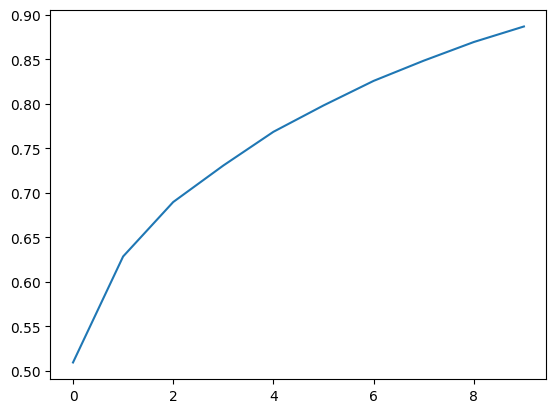

In [59]:
plt.plot(out_data[2][10][4])

In [48]:
l = np.array(out_data[2][10][4])

In [49]:
d = l[1:] - l[:-1]

In [50]:
d[1:]/d[:-1]

array([0.51347299, 0.67045562, 0.92380075, 0.78201846, 0.93158866,
       0.8222059 , 0.92448197])